<a href="https://colab.research.google.com/github/QuatZo/kickstarter-predictor/blob/master/classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries & dataset

In [0]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import time

from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report

from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from imblearn.over_sampling import SMOTE

df = pd.read_csv('http://puma.swstats.info/files/kickstarter_with_trends.csv', index_col="ID")
df.columns

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Index(['name', 'category', 'main_category', 'currency', 'deadline', 'goal',
       'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged',
       'usd_pledged_real', 'usd_goal_real', 'tokenized_name', 'trend'],
      dtype='object')

# Clean & prepare data
* Calculate campaign length 
* Delete all incomplete data (like country == N,0")
* Delete all kickstarter projects with different state than 'failed' and 'successful' 
* Cast to numerical types all non-numerical features and drop all empty data
* Use Label Encoding or One-Hot Encoding

In [0]:
df_clean = df.copy()

indexes = df_clean[df_clean['country'] == 'N,0"'].index
df_clean.drop(indexes, inplace=True)
# keep only failed & successful records, we drop here like 40k
# indexes = df_clean[(df_clean['state'] != 'failed') & (df_clean['state'] != 'successful')].index
# df_clean.drop(indexes, inplace=True)

df_clean['campaign_length'] = pd.to_timedelta((pd.to_datetime(df_clean['deadline']) - pd.to_datetime(df_clean['launched'])), unit='days').dt.days
# df_clean['name_length'] = df_clean['name'].str.len() # totaly useless since we are using name to get trend

##########################################################
# """ Label Encoding - if you want to run this, just comment lines with quotation marks
for col in ['category', 'main_category', 'currency', 'country']:
  for index, value in enumerate(df_clean[col].unique()):
    df_clean[col].replace(value, index, inplace=True)

df_xd = df_clean[~df_clean['state'].str.contains('successful')].index
df_clean.loc[df_clean['state'].str.contains('successful'), 'state'] = 1
df_clean.loc[df_xd, 'state'] = 0
df_clean['state'] = df_clean['state'].astype(int)
df_clean.drop(['tokenized_name'], inplace=True, axis=1)
df_clean.dropna(inplace=True)
# """
##########################################################

##########################################################
""" One-Hot Encoding - if you want to run this, just comment lines with quotation marks
for index, value in enumerate(df_clean['state'].unique()):
  df_clean['state'].replace(value, index, inplace=True)

column_transformer = ColumnTransformer([('encoder', OneHotEncoder(), ['category', 'main_category', 'currency', 'country'])], sparse_threshold=0, n_jobs=-1)
onehot = pd.DataFrame(column_transformer.fit_transform(df_clean)).set_index(df_clean.index)
new_cols_encoding = [col.replace('encoder__x0_', '').replace('encoder__x1_', '').replace('encoder__x2_', '').replace('encoder__x3_', '') for col in column_transformer.get_feature_names()]
onehot.columns = new_cols_encoding
df_clean = pd.concat([df_clean, onehot], axis=1)
df_clean.drop(['category', 'main_category', 'currency', 'country', 'tokenized_name'], inplace=True, axis=1)
df_clean = df_clean.loc[:,~df_clean.columns.duplicated()]
"""
##########################################################

df_clean

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,trend,campaign_length
ID,,,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,0,0,0,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,0,0.0,0.0,1533.95,26.526034,58
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,1,1,1,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,1,100.0,2421.0,30000.00,13.684380,59
1000004038,Where is Hank?,1,1,1,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,1,220.0,220.0,45000.00,35.000000,44
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,2,2,1,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,1,1.0,1.0,5000.00,28.000000,29
1000011046,Community Film Project: The Art of Neighborhoo...,3,1,1,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,0,14,1,1283.0,1283.0,19500.00,21.800000,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),8,1,1,2014-10-17,50000.0,2014-09-17 02:35:30,25.0,0,1,1,25.0,25.0,50000.00,19.000000,29
999977640,The Tribe,1,1,1,2011-07-19,1500.0,2011-06-22 03:35:14,155.0,0,5,1,155.0,155.0,1500.00,56.000000,26
999986353,Walls of Remedy- New lesbian Romantic Comedy f...,1,1,1,2010-08-16,15000.0,2010-07-01 19:40:30,20.0,0,1,1,20.0,20.0,15000.00,18.000000,45


# Check features correlation
We say features are dependant, if abs(correlation) > .5

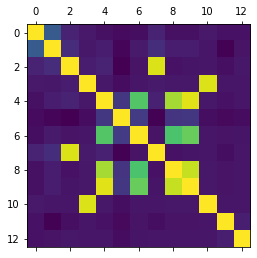

,category,main_category,currency,goal,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,trend,campaign_length
category,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
main_category,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
currency,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,0.944815,NaN,NaN,NaN,NaN,NaN
goal,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.942691,NaN,NaN
pledged,NaN,NaN,NaN,NaN,1.000000,NaN,0.717858,NaN,0.857370,0.952736,NaN,NaN,NaN
state,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
backers,NaN,NaN,NaN,NaN,0.717858,NaN,1.000000,NaN,0.697426,0.753449,NaN,NaN,NaN
country,NaN,NaN,0.944815,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
usd pledged,NaN,NaN,NaN,NaN,0.857370,NaN,0.697426,NaN,1.000000,0.907743,NaN,NaN,NaN
usd_pledged_real,NaN,NaN,NaN,NaN,0.952736,NaN,0.753449,NaN,0.907743,1.000000,NaN,NaN,NaN


In [0]:
corr = df_clean.corr()

plt.matshow(corr)
plt.show()

corr[(corr > .5) | (corr < -.5)]

# Delete unnecessary features
We delete dupe features (like converted goal value) and the ones that user won't be able to provide, like backers.

In [0]:
df_shortened = df_clean.copy()
df_shortened.drop(['pledged', 'backers', 'usd pledged', 'deadline', 'launched', 'name', 'usd_pledged_real', 'usd_goal_real'], axis=1, inplace=True)
df_shortened

,category,main_category,currency,goal,state,country,trend,campaign_length
ID,,,,,,,,
1000002330,0,0,0,1000.0,0,0,26.526034,58
1000003930,1,1,1,30000.0,0,1,13.684380,59
1000004038,1,1,1,45000.0,0,1,35.000000,44
1000007540,2,2,1,5000.0,0,1,28.000000,29
1000011046,3,1,1,19500.0,0,1,21.800000,55
...,...,...,...,...,...,...,...,...
999976400,8,1,1,50000.0,0,1,19.000000,29
999977640,1,1,1,1500.0,0,1,56.000000,26
999986353,1,1,1,15000.0,0,1,18.000000,45


# Split data
Split data for training & test set, with 10% being in test set. 30k is enough for testing.

In [0]:
X = df_shortened.drop('state', axis=1)
y = df_shortened['state']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1) # 90%:10%
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1) # 81%:9% -> 90%
len(X_test)

37486

# Data Oversampling (SMOTE)

In [0]:
sm = SMOTE(n_jobs=-1)

X_train_cols = X_train.columns
X_train, y_train = sm.fit_sample(X_train, y_train)
X_train = pd.DataFrame(X_train)
X_train.columns = X_train_cols

pd.Series(y_train).value_counts()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1    195212
0    195212
dtype: int64

# (Optional) Delete all irrelevant features
Delete all irrelevant features, but keep AT MAX 5

In [0]:
""" If you want to use this cell, just comment lines with quotation marks at the beginning
logistic = LogisticRegression(C=1, penalty="l2", max_iter=1000).fit(X_train, y_train)
model = SelectFromModel(logistic, prefit=True, max_features=5)

X_new = model.transform(X_train)

selected_features = pd.DataFrame(model.inverse_transform(X_new), index=X_train.index, columns=X_train.columns)
selected_columns = selected_features.columns[selected_features.var() != 0]

X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

selected_features
"""

' If you want to use this cell, just comment lines with quotation marks at the beginning\nlogistic = LogisticRegression(C=1, penalty="l2", max_iter=1000).fit(X_train, y_train)\nmodel = SelectFromModel(logistic, prefit=True, max_features=5)\n\nX_new = model.transform(X_train)\n\nselected_features = pd.DataFrame(model.inverse_transform(X_new), index=X_train.index, columns=X_train.columns)\nselected_columns = selected_features.columns[selected_features.var() != 0]\n\nX_train = X_train[selected_columns]\nX_test = X_test[selected_columns]\n\nselected_features\n'

# Standarization & min-max scaling
Standarization -> mean-std

Min-Max scaling -> min-max

In [0]:
##########################################################
"""min-max normalization: (value - min) / (max - min) - if you want to run this, just comment lines with quotation marks
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())
"""
##########################################################

##########################################################
# """mean-std standarization: (sample - mean) / standard_deviation - if you want to run this, just comment lines with quotation marks
cols = X_train.columns
indexes_x_train = X_train.index
indexes_x_test = X_test.index

scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train)).set_index(indexes_x_train)
X_test = pd.DataFrame(scaler.transform(X_test)).set_index(indexes_x_test)
X_train.columns = cols
X_test.columns = cols
# """
##########################################################
X_train

,category,main_category,currency,goal,country,trend,campaign_length
0,-0.194788,-1.222949,-0.217683,-0.037124,-0.225324,-0.933407,-0.098900
1,2.275386,1.009146,-0.217683,-0.036146,-0.225324,-0.246693,-0.032752
2,-0.194788,-1.222949,-0.217683,-0.038593,-0.225324,-0.043481,-0.065826
3,0.618917,1.505167,-0.217683,-0.028022,-0.225324,0.692284,-0.065826
4,0.124882,0.265114,-0.217683,-0.029784,-0.225324,-0.765232,-0.065826
...,...,...,...,...,...,...,...
390419,-1.013056,-0.765879,-0.217683,-0.012167,-0.225324,0.049814,-0.027558
390420,0.124882,0.265114,-0.217683,-0.039082,-0.225324,-1.089909,-0.065826
390421,1.490743,-0.726928,-0.217683,-0.034678,-0.225324,-0.031562,-0.065826
390422,0.047431,-0.228645,2.746742,-0.034678,4.382688,-1.457150,-0.099050


# SVC Classifier
Since it's not a Linear Classifier, 350k rows is too much for this algorithm. It takes roughtly 2 hours to compute with only 55% accuracy. It's still here because it's worth mentioning that we tried it.

In [0]:
# classifier = SVC(gamma='auto', verbose=1, random_state=420)
# classifier.fit(X_train, y_train)
# predict is to predict, score is to get model accuracy
# classifier.score(X_test, y_test)

# SVC Linear Classifier
Same as above, except it's linear and handles huge amount of input data. Takes ~60 seconds to train prediction model. Unless you turn off 'dual' parameter, then 1 second.

In [0]:
svc_linear_start = time.time()

classifier_linear = LinearSVC(verbose=1, dual=False)
classifier_linear.fit(X_train, y_train)
# predict is to predict, score is to get model accuracy
print("Score:", classifier_linear.score(X_test, y_test))
print("Training time:", time.time() - svc_linear_start)

[LibLinear]Score: 0.554180227284853
Training time: 1.377040147781372


# SVC Linear Search Best Parameters
Script used to find the best parameters for Linear SVC.

In [0]:
parameters_svc = {
    'loss': ['squared_hinge', 'hinge'],
    'tol': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2],
    'C': [1, 3, 5, 7, 9],
}

# the best version
svc_brute_force = LinearSVC(verbose=2, dual=False)
grid_svc = GridSearchCV(svc_brute_force, param_grid=parameters_svc, verbose=5, cv=4)
grid_svc = grid_svc.fit(X_train, y_train)

print("Best parameters for Linear SVC:", grid_svc.best_params_)
print("Best score for above parameters:", grid_svc.best_score_)
print("Accuracy of Linear SVC Model w/ best parameters:", grid_svc.score(X_test, y_test))

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV] C=1, loss=squared_hinge, tol=1e-07 ..............................
[LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. C=1, loss=squared_hinge, tol=1e-07, score=0.598, total=   0.5s
[CV] C=1, loss=squared_hinge, tol=1e-07 ..............................
[LibLinear]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV] .. C=1, loss=squared_hinge, tol=1e-07, score=0.596, total=   0.5s


KeyboardInterrupt: ignored

# SVC Linear Best Parameters
Best parameters actually gave the same accuracy as default parameters.

Best parameters for Linear SVC: {'C': 3, 'loss': 'squared_hinge', 'tol': 1e-07}

Best score for above parameters: 0.6058348920660341

Accuracy of Linear SVC Model w/ best parameters: 0.6087914077113378

# XGBoost Classifier
Use XGBoost method to train a classification model. It takes ~1s to compute by using GPU, ~67% accuracy (better than LinearSVC).

In [0]:
xgb_start = time.time()

# hist speeds up computation time 2.5x
# gpu_hist faster 2.5x than hist
# gpu_hist with TPU gives error
# hist with TPU fast like hist
# winner is gpu_hist with GPU
classifier_xgb = xgb.XGBClassifier(verbosity=2, tree_method='gpu_hist')
classifier_xgb.fit(X_train, y_train)

print("Score:", classifier_xgb.score(X_test, y_test))
print("Training time:", time.time() - xgb_start)

Score: 0.6691298084618258
Training time: 0.4068119525909424


# XGBoost Feature Selection

In [0]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

efs_xgb_start = time.time()

efs_xgb = EFS(classifier_xgb, max_features=X_train.shape[1], n_jobs=-1)
efs_xgb.fit(X_train, y_train)

print("\nBest accuracy score:", efs_xgb.best_score_)
print("Best subset (indices):", efs_xgb.best_idx_)
print("Best subset (corresponding names):", efs_xgb.best_feature_names_)
print("Computation time:", time.time() - efs_xgb_start)

Features: 63/63

Best accuracy score: 0.6716190328506588
Best subset (indices): (0, 1, 3, 4, 5)
Best subset (corresponding names): ('category', 'main_category', 'goal', 'country', 'campaign_length')
Computation time: 965.6234011650085


# XGBoost Classification Report

In [0]:
y_xgb = classifier_xgb.predict(X_test)
print(classification_report(y_test, y_xgb))

              precision    recall  f1-score   support

           0       0.76      0.71      0.73     24064
           1       0.53      0.59      0.56     13422

    accuracy                           0.67     37486
   macro avg       0.65      0.65      0.65     37486
weighted avg       0.68      0.67      0.67     37486



# XGBoost Search Best Parameters
Brute-force this classifier, to find the best parameters.

In [0]:
parameters = {
    'subsample': [.8, .1],
    'colsample_bytree': [.8, 1],
    'max_depth': [4, 10],
    'learning_rate': [.1, 1],
    'reg_alpha':[1e-3, 1e-7],
    'gamma': [0, 1e-3],
    'sampling_method': ['uniform', 'gradient_based'], # gradient_based only for gpu_hist - probably because of heavy calculations
    'grow_policy': ['depthwise', 'lossguide'],
    'num_parallel_tree': [1, 5],
    'max_leaves': [0, 30],
}

# the best version
xgb_brute_force = xgb.XGBClassifier(verbosity=2, tree_method='gpu_hist', objective='binary:logistic')
grid_obj = GridSearchCV(xgb_brute_force, param_grid=parameters, verbose=5, cv=4)
grid_obj = grid_obj.fit(X_train, y_train)

print("Best parameters for XGB:", grid_obj.best_params_)
print("Best score for above parameters:", grid_obj.best_score_)
print("Accuracy of XGB Model w/ best parameters:", grid_obj.score(X_test, y_test))

Fitting 4 folds for each of 1024 candidates, totalling 4096 fits
[CV] colsample_bytree=0.8, gamma=0, grow_policy=depthwise, learning_rate=0.1, max_depth=4, max_leaves=0, num_parallel_tree=1, reg_alpha=0.001, sampling_method=uniform, subsample=0.8 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.8, gamma=0, grow_policy=depthwise, learning_rate=0.1, max_depth=4, max_leaves=0, num_parallel_tree=1, reg_alpha=0.001, sampling_method=uniform, subsample=0.8, score=0.677, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0, grow_policy=depthwise, learning_rate=0.1, max_depth=4, max_leaves=0, num_parallel_tree=1, reg_alpha=0.001, sampling_method=uniform, subsample=0.8 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  colsample_bytree=0.8, gamma=0, grow_policy=depthwise, learning_rate=0.1, max_depth=4, max_leaves=0, num_parallel_tree=1, reg_alpha=0.001, sampling_method=uniform, subsample=0.8, score=0.680, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0, grow_policy=depthwise, learning_rate=0.1, max_depth=4, max_leaves=0, num_parallel_tree=1, reg_alpha=0.001, sampling_method=uniform, subsample=0.8 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  colsample_bytree=0.8, gamma=0, grow_policy=depthwise, learning_rate=0.1, max_depth=4, max_leaves=0, num_parallel_tree=1, reg_alpha=0.001, sampling_method=uniform, subsample=0.8, score=0.677, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0, grow_policy=depthwise, learning_rate=0.1, max_depth=4, max_leaves=0, num_parallel_tree=1, reg_alpha=0.001, sampling_method=uniform, subsample=0.8 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.2s remaining:    0.0s


[CV]  colsample_bytree=0.8, gamma=0, grow_policy=depthwise, learning_rate=0.1, max_depth=4, max_leaves=0, num_parallel_tree=1, reg_alpha=0.001, sampling_method=uniform, subsample=0.8, score=0.680, total=   0.4s
[CV] colsample_bytree=0.8, gamma=0, grow_policy=depthwise, learning_rate=0.1, max_depth=4, max_leaves=0, num_parallel_tree=1, reg_alpha=0.001, sampling_method=uniform, subsample=0.1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.6s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
[CV]  colsample_bytree=0.8, gamma=0.001, grow_policy=lossguide, learning_rate=0.1, max_depth=4, max_leaves=0, num_parallel_tree=5, reg_alpha=1e-07, sampling_method=gradient_based, subsample=0.1, score=0.678, total=   1.4s
[CV] colsample_bytree=0.8, gamma=0.001, grow_policy=lossguide, learning_rate=0.1, max_depth=4, max_leaves=0, num_parallel_tree=5, reg_alpha=1e-07, sampling_method=gradient_based, subsample=0.1 
[CV]  colsample_bytree=0.8, gamma=0.001, grow_policy=lossguide, learning_rate=0.1, max_depth=4, max_leaves=0, num_parallel_tree=5, reg_alpha=1e-07, sampling_method=gradient_based, subsample=0.1, score=0.681, total=   1.4s
[CV] colsample_bytree=0.8, gamma=0.001, grow_policy=lossguide, learning_rate=0.1, max_depth=4, max_leaves=0, num_parallel_tree=5, reg_alpha=1e-07, sampling_method=gradient_based, subsample=0.1 
[CV]  colsample_bytree=0.8, gamma=0.001, grow_policy=lossguide, learning_rate=0.1, max_depth=4, max_leaves=0, num_par

[Parallel(n_jobs=1)]: Done 4096 out of 4096 | elapsed: 180.2min finished


Best parameters for XGB: {'colsample_bytree': 0.8, 'gamma': 0, 'grow_policy': 'depthwise', 'learning_rate': 0.1, 'max_depth': 10, 'max_leaves': 0, 'num_parallel_tree': 5, 'reg_alpha': 0.001, 'sampling_method': 'uniform', 'subsample': 0.8}
Best score for above parameters: 0.6877968822744671
Accuracy of XGB Model w/ best parameters: 0.6867495323719303


# XGBoost Best Parameters
2% accuracy boost between default & best parameter models

Best parameters for XGB: {'colsample_bytree': 0.8, 'gamma': 0, 'grow_policy': 'depthwise', 'learning_rate': 0.1, 'max_depth': 10, 'max_leaves': 0, 'num_parallel_tree': 5, 'reg_alpha': 0.001, 'sampling_method': 'uniform', 'subsample': 0.8}

Best score for above parameters: 0.6877968822744671

Accuracy of XGB Model w/ best parameters: 0.6867495323719303

# XGBoost Best Parameters over/under-fitting
Since every value (error & logloss for train & test data) decreases, model is not overfitting. The accuracy for non-related test set says that model is also not underfitting. 

In [0]:
xgb_start = time.time()

classifier_xgb_fitting = xgb.XGBClassifier(verbosity=1, tree_method='gpu_hist', colsample_bytree=.8, 
                                           gamma=0, grow_policy='depthwise', learning_rate=.1, max_depth=10, max_leaves=0, 
                                           num_parallel_tree=5, reg_alpha=.001, sampling_method='uniform', subsample=.8)
xgb_eval_set = [(X_train, y_train), (X_test, y_test)]

classifier_xgb_fitting.fit(X_train, y_train, eval_set=xgb_eval_set, eval_metric=['error', 'logloss'])

print("Score:", classifier_xgb_fitting.score(X_test,y_test))
print("Training time:", time.time() - xgb_start)

# validation_0 - Train Set
# validation_1 - Test Set

[0]	validation_0-error:0.313445	validation_0-logloss:0.676977	validation_1-error:0.354052	validation_1-logloss:0.681119
[1]	validation_0-error:0.310167	validation_0-logloss:0.66208	validation_1-error:0.346449	validation_1-logloss:0.67028
[2]	validation_0-error:0.304499	validation_0-logloss:0.649815	validation_1-error:0.342368	validation_1-logloss:0.662273
[3]	validation_0-error:0.300119	validation_0-logloss:0.638474	validation_1-error:0.341407	validation_1-logloss:0.654824
[4]	validation_0-error:0.29638	validation_0-logloss:0.628327	validation_1-error:0.338073	validation_1-logloss:0.648623
[5]	validation_0-error:0.295076	validation_0-logloss:0.619739	validation_1-error:0.338046	validation_1-logloss:0.642863
[6]	validation_0-error:0.292208	validation_0-logloss:0.61171	validation_1-error:0.336232	validation_1-logloss:0.638057
[7]	validation_0-error:0.289789	validation_0-logloss:0.60419	validation_1-error:0.333298	validation_1-logloss:0.63287
[8]	validation_0-error:0.288192	validation_0-l

# XGBoost Features Importance
Bar plot to check which features are 'the most important' for our model

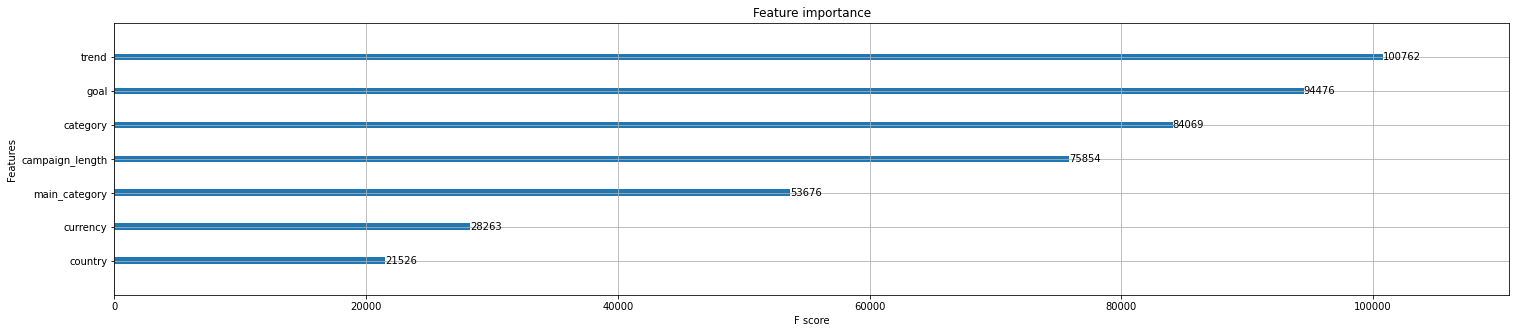

In [0]:
plt.rcParams["figure.figsize"] = (25, 5)
xgb.plot_importance(classifier_xgb_fitting)
plt.show()

# Dart XGBoost
XGBoost with different booster - 'dart' instead of 'gbtree'. Takes a lot more time to compute with very similar, if not the same accuracy.

In [0]:
dart_start = time.time()

classifier_xgb_dart = xgb.XGBClassifier(booster='dart', verbosity=1, tree_method='gpu_hist')
classifier_xgb_dart.fit(X_train, y_train)

print("Score:", classifier_xgb_dart.score(X_test,y_test))
print("Training time:", time.time() - dart_start)

Score: 0.6691298084618258
Training time: 60.32905554771423


# Dart XGBoost Search Best Parameters
Find best parameters for Dart XGBoost.

In [0]:
parameters_dart = {
  'sample_type' : ['weighted','uniform'],
  'normalize_type' : ['tree','forest'],
  'skip_drop': [0, .1, .25, .5],
  'rate_drop': [0, .1, .25, .5],
  'one_drop': [0, 1],
}

dart_xgb_brute_force = xgb.XGBClassifier(verbosity=2, tree_method='gpu_hist', booster='dart')

grid_obj_dart = GridSearchCV(dart_xgb_brute_force, param_grid=parameters_dart, verbose=5, cv=4, n_jobs=-1)
grid_obj_dart = grid_obj_dart.fit(X_train, y_train)

print("Best parameters for Dart XGB:", grid_obj_dart.best_params_)
print("Best score for above parameters:", grid_obj_dart.best_score_)
print("Accuracy of Dart XGB Model w/ best parameters:", grid_obj_dart.score(X_test, y_test))

Fitting 4 folds for each of 128 candidates, totalling 512 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed: 51.8min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 82.1min
[Parallel(n_jobs=-1)]: Done 512 out of 512 | elapsed: 94.3min finished


[07:51:37] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[07:51:37] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[07:51:37] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[07:51:37] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[07:51:37] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[07:51:38] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[07:51:38] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[07:51:38] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[07:51:38] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[07:51:38] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[07:51:38] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[07:51:38] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[07:51:38] INFO: /workspace/src/gbm/gbtree.cc:479: drop 0 trees, weight = 1
[07:51:38] I

# Dart XGBoost Best Parameters
Minimum Accuracy Boost

Best parameters for Dart XGB: {'normalize_type': 'tree', 'one_drop': 0, 'rate_drop': 0, 'sample_type': 'weighted', 'skip_drop': 0}

Best score for above parameters: 0.6702446113888296

Accuracy of Dart XGB Model w/ best parameters: 0.6714837386109938

# Dart XGBoost Best Parameters over/under-fitting
Since every value (error & logloss for train & test data) decreases, model is not overfitting. The accuracy for non-related test set says that model is also not underfitting. 

In [0]:
xgb_start = time.time()

classifier_dart_xgb_fitting = xgb.XGBClassifier(verbosity=1, tree_method='gpu_hist', booster='dart', normalize_type='tree', 
                                                one_drop=0, rate_drop=0, sample_type='weighted', skip_drop=0, n_estimators=300)
xgb_eval_set = [(X_train, y_train), (X_test, y_test)]

classifier_dart_xgb_fitting.fit(X_train, y_train, eval_set=xgb_eval_set, eval_metric=['error', 'logloss'])

print("Score:", classifier_dart_xgb_fitting.score(X_test,y_test))
print("Training time:", time.time() - xgb_start)

# validation_0 - Train Set
# validation_1 - Test Set

[0]	validation_0-error:0.392789	validation_0-logloss:0.685918	validation_1-error:0.396655	validation_1-logloss:0.686586
[1]	validation_0-error:0.388681	validation_0-logloss:0.679747	validation_1-error:0.422851	validation_1-logloss:0.681003
[2]	validation_0-error:0.388645	validation_0-logloss:0.674653	validation_1-error:0.424105	validation_1-logloss:0.676096
[3]	validation_0-error:0.384993	validation_0-logloss:0.670443	validation_1-error:0.416742	validation_1-logloss:0.672066
[4]	validation_0-error:0.380178	validation_0-logloss:0.666812	validation_1-error:0.409139	validation_1-logloss:0.668934
[5]	validation_0-error:0.376488	validation_0-logloss:0.663277	validation_1-error:0.403191	validation_1-logloss:0.666242
[6]	validation_0-error:0.377121	validation_0-logloss:0.660209	validation_1-error:0.404284	validation_1-logloss:0.663703
[7]	validation_0-error:0.378897	validation_0-logloss:0.657202	validation_1-error:0.40946	validation_1-logloss:0.661184
[8]	validation_0-error:0.373113	validatio

# Dart XGBoost Features Importance
Bar plot to visualize which features are 'the most important'.

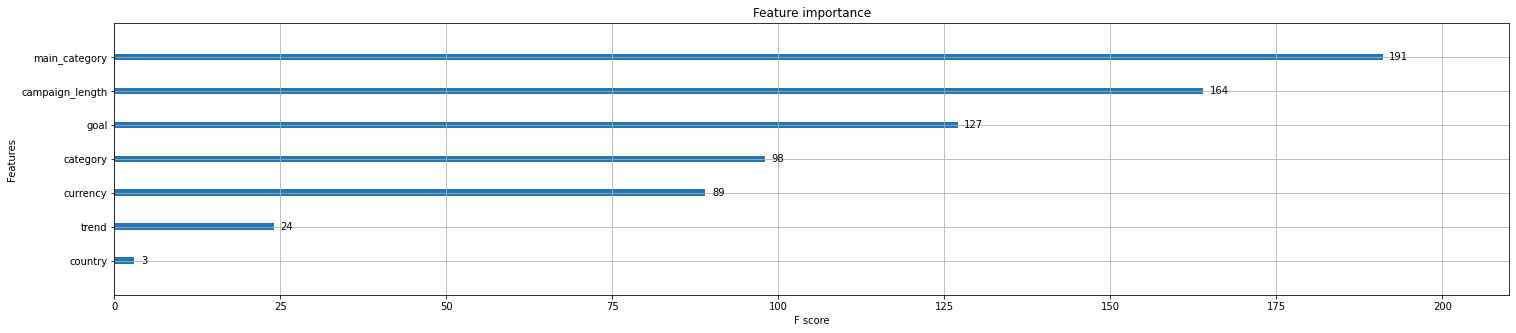

In [0]:
plt.rcParams["figure.figsize"] = (25, 5)
xgb.plot_importance(classifier_dart_xgb_fitting)
plt.show()

# Random Forest Classifier
Random Forest Classifier with default parameters, gives ~64% accuracy in 20s, so higher than SVC

In [0]:
rand_forest_start = time.time()

random_forest_clf = RandomForestClassifier(verbose=1, n_jobs=-1)
random_forest_clf.fit(X_train, y_train)

print("Score:", random_forest_clf.score(X_test, y_test))
print("Training time:", time.time() - rand_forest_start)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s


Score: 0.655471375980366
Training time: 30.472777843475342


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


# Random Forest Search Best Parameters
Brute-force this classifier, to find the best parameters.

In [0]:
parameters_forest = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 10],
    'min_samples_split': [2, 1e-7, 1e-3, .1],
    'min_samples_leaf': [1, 1e-7, 1e-3, .1],
    'oob_score': [True, False],
    'ccp_alpha': [0, 1],
}

# the best version
random_forest_clf = RandomForestClassifier(verbose=1, n_jobs=-1)
grid_obj_forest = GridSearchCV(random_forest_clf, param_grid=parameters_forest, verbose=5, cv=4)
grid_obj_forest = grid_obj_forest.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_obj_forest.best_params_)
print("Best score for above parameters:", grid_obj_forest.best_score_)
print("Accuracy of Random Forest Model w/ best parameters:", grid_obj_forest.score(X_test, y_test))

Fitting 4 folds for each of 384 candidates, totalling 1536 fits
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.621, total=   3.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.623, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.621, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.621, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.620, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.622, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.619, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.620, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.621, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.624, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.621, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.621, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.621, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.622, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.620, total=   2.7s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.621, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.621, total=   8.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.622, total=   8.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.621, total=   8.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.622, total=   8.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.621, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.622, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.620, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.621, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.620, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.622, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.621, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.621, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.620, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.621, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.621, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.623, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.621, total=   4.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.623, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.621, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.621, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.621, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.621, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.621, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.621, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.621, total=   8.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.621, total=   8.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.621, total=   8.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.621, total=   8.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.621, total=   5.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.622, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.621, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.621, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.622, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.622, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.621, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.621, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.621, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.623, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.621, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.622, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.621, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.623, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.620, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.621, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.621, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.622, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.621, total=   2.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.622, total=   2.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.621, total=   8.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.621, total=   8.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.621, total=   8.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.621, total=   8.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.621, total=   5.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.621, total=   5.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.621, total=   5.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.622, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.620, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.621, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.620, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.620, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.620, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.620, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.620, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.620, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.620, total=   4.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.622, total=   4.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.620, total=   4.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.621, total=   4.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.620, total=   2.7s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.622, total=   2.7s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.619, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.620, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.620, total=   8.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.621, total=   8.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.620, total=   8.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.620, total=   8.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.620, total=   5.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.621, total=   5.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.620, total=   5.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.621, total=   5.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True, score=0.621, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True, score=0.623, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True, score=0.620, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True, score=0.622, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False, score=0.621, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False, score=0.621, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False, score=0.620, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False, score=0.622, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True, score=0.621, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True, score=0.622, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True, score=0.622, total=   4.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True, score=0.622, total=   4.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False, score=0.620, total=   2.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False, score=0.621, total=   2.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False, score=0.621, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False, score=0.621, total=   2.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True, score=0.622, total=   8.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True, score=0.622, total=   8.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True, score=0.621, total=   8.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True, score=0.622, total=   8.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False, score=0.621, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False, score=0.622, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False, score=0.621, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False, score=0.621, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.621, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.623, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.620, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.620, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.622, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.622, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.621, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.621, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.621, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.621, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.620, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.622, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.620, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.623, total=   2.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.621, total=   2.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.621, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.622, total=   8.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.621, total=   8.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.620, total=   8.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.621, total=   8.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.621, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.622, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.621, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.621, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.620, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.621, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.621, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.621, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.621, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.623, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.620, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.621, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.620, total=   4.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.623, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.621, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.622, total=   4.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.621, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.622, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.621, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.621, total=   2.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.622, total=   8.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.622, total=   8.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.621, total=   8.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.621, total=   8.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.622, total=   5.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.621, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.621, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.622, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.620, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.621, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.619, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.620, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.620, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.621, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.620, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.620, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.620, total=   4.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.621, total=   4.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.620, total=   4.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.620, total=   4.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.620, total=   2.7s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.621, total=   2.7s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.620, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.620, total=   2.7s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.620, total=   8.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.621, total=   8.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.620, total=   8.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.620, total=   8.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.620, total=   5.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.621, total=   5.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.620, total=   5.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.621, total=   5.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True, score=0.622, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True, score=0.622, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True, score=0.620, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True, score=0.622, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False, score=0.621, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False, score=0.623, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False, score=0.621, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False, score=0.624, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True, score=0.620, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True, score=0.622, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True, score=0.621, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True, score=0.622, total=   4.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False, score=0.622, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False, score=0.622, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False, score=0.620, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False, score=0.622, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True, score=0.621, total=   8.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True, score=0.622, total=   8.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True, score=0.622, total=   8.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True, score=0.621, total=   8.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False, score=0.622, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False, score=0.622, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False, score=0.621, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False, score=0.621, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.621, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.621, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.621, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.621, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.620, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.622, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.621, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.622, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.621, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.622, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.621, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.620, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.622, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.621, total=   2.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.621, total=   2.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.621, total=   2.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.622, total=   8.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.622, total=   8.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.622, total=   8.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.621, total=   8.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.621, total=   5.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.621, total=   5.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.621, total=   5.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.621, total=   5.7s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.621, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.622, total=   2.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.620, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.622, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.620, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.623, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.621, total=   1.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.621, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.620, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.621, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.621, total=   4.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.622, total=   4.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.621, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.621, total=   2.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.621, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.621, total=   2.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.621, total=   8.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.621, total=   8.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.621, total=   8.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.622, total=   8.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.622, total=   5.7s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.622, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.620, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.622, total=   5.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.620, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.621, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.620, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.620, total=   2.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.620, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.621, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.620, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.620, total=   1.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.620, total=   4.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.622, total=   4.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.620, total=   4.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.620, total=   4.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.620, total=   2.7s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.621, total=   2.7s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.620, total=   2.7s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.620, total=   2.7s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.620, total=   8.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.621, total=   8.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.620, total=   8.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.620, total=   8.1s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.620, total=   5.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.621, total=   5.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.620, total=   5.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.620, total=   5.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   1.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.598, total=   2.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.601, total=   2.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   1.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.597, total=   1.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.603, total=   3.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.601, total=   2.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.602, total=   2.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.600, total=   7.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   7.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   7.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   7.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   4.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.600, total=   4.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.602, total=   4.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.599, total=   2.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.599, total=   2.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.604, total=   4.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.600, total=   2.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.604, total=   2.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.600, total=   2.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   7.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.601, total=   7.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   7.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   7.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.601, total=   4.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.598, total=   4.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.603, total=   4.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.602, total=   2.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.601, total=   2.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.599, total=   2.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.605, total=   2.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.604, total=   1.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.600, total=   3.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.598, total=   2.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.602, total=   7.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   7.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   7.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   7.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.603, total=   4.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.602, total=   2.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.604, total=   2.0s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.597, total=   1.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.599, total=   1.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.2s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.603, total=   2.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   7.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   7.5s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.597, total=   7.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.603, total=   7.6s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   4.8s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   4.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   4.9s
[CV] ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.600, total=   4.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.664, total=   4.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.669, total=   4.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.669, total=   4.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.668, total=   4.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.667, total=   3.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.670, total=   3.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.668, total=   3.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.668, total=   3.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.666, total=   8.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.670, total=   8.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.669, total=   8.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.666, total=   8.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.666, total=   6.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.671, total=   6.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.669, total=   6.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.667, total=   6.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.666, total=  16.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.670, total=  16.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.668, total=  16.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.667, total=  16.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.666, total=  12.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.670, total=  12.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.668, total=  12.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.668, total=  12.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.666, total=   4.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.669, total=   4.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.666, total=   4.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.666, total=   4.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.664, total=   3.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.671, total=   3.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.668, total=   3.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.667, total=   3.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.666, total=   8.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.672, total=   8.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.668, total=   8.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.668, total=   8.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.667, total=   6.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.670, total=   6.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.668, total=   6.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.668, total=   6.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.665, total=  16.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.670, total=  16.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.668, total=  16.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.666, total=  16.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.665, total=  12.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.670, total=  12.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.668, total=  12.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.668, total=  12.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.665, total=   4.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.670, total=   4.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.667, total=   4.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.667, total=   4.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.664, total=   3.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.669, total=   3.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.664, total=   3.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.665, total=   3.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.664, total=   8.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.668, total=   8.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.667, total=   8.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.666, total=   8.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.665, total=   6.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.668, total=   6.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.667, total=   6.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.669, total=   6.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.665, total=  16.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.669, total=  16.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.668, total=  16.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.664, total=  16.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.665, total=  12.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.670, total=  12.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.668, total=  12.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.665, total=  12.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.635, total=   2.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.635, total=   2.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.633, total=   2.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.631, total=   2.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.633, total=   1.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.633, total=   1.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.631, total=   1.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.632, total=   1.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.635, total=   5.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.635, total=   5.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.634, total=   5.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    3.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.634, total=   5.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.635, total=   3.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.634, total=   3.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.634, total=   3.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.635, total=   3.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.633, total=  10.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.634, total=  10.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.632, total=  10.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.634, total=  10.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.634, total=   7.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.633, total=   7.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.634, total=   7.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.634, total=   7.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True, score=0.665, total=   4.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True, score=0.670, total=   4.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True, score=0.670, total=   4.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True, score=0.667, total=   4.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False, score=0.664, total=   3.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False, score=0.668, total=   3.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False, score=0.669, total=   3.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False, score=0.668, total=   3.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True, score=0.666, total=   8.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True, score=0.671, total=   8.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True, score=0.666, total=   8.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True, score=0.668, total=   8.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False, score=0.665, total=   6.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False, score=0.669, total=   6.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False, score=0.669, total=   6.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False, score=0.667, total=   6.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True, score=0.665, total=  16.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True, score=0.670, total=  16.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True, score=0.669, total=  16.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True, score=0.669, total=  17.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.7s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False, score=0.667, total=  12.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False, score=0.670, total=  12.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False, score=0.669, total=  12.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False, score=0.667, total=  12.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.665, total=   4.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.670, total=   4.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.668, total=   4.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.668, total=   4.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.665, total=   3.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.670, total=   3.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.669, total=   3.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.666, total=   3.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.667, total=   8.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.670, total=   8.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.668, total=   8.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.668, total=   8.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.666, total=   6.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.670, total=   6.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.669, total=   6.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.667, total=   6.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.666, total=  16.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.670, total=  17.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.669, total=  16.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.666, total=  17.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.664, total=  12.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.670, total=  12.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.669, total=  12.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.668, total=  12.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.662, total=   4.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.670, total=   4.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.665, total=   4.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.669, total=   4.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.665, total=   3.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.668, total=   3.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.668, total=   3.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.666, total=   3.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.663, total=   8.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.670, total=   8.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.667, total=   8.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.667, total=   8.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.665, total=   6.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.669, total=   6.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.668, total=   6.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.668, total=   6.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.664, total=  16.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.670, total=  16.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.667, total=  16.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.666, total=  16.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.664, total=  12.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.669, total=  12.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.668, total=  12.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.665, total=  12.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.635, total=   2.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.634, total=   2.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.637, total=   2.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.634, total=   2.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.632, total=   1.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.634, total=   1.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.633, total=   1.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.631, total=   1.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    3.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.632, total=   5.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.635, total=   5.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.635, total=   5.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.633, total=   5.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    3.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.633, total=   3.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.635, total=   3.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.634, total=   3.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.633, total=   3.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.634, total=  10.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.635, total=  10.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.635, total=  10.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.635, total=  10.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.634, total=   7.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.634, total=   7.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.634, total=   7.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.634, total=   6.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True, score=0.662, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True, score=0.666, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True, score=0.666, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True, score=0.660, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False, score=0.660, total=   3.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False, score=0.668, total=   3.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False, score=0.666, total=   3.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False, score=0.662, total=   3.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True, score=0.662, total=   8.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True, score=0.667, total=   8.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True, score=0.664, total=   8.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True, score=0.664, total=   8.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False, score=0.662, total=   5.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False, score=0.667, total=   5.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False, score=0.663, total=   5.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False, score=0.663, total=   5.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True, score=0.662, total=  15.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True, score=0.666, total=  15.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True, score=0.665, total=  15.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True, score=0.662, total=  15.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False, score=0.661, total=  11.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False, score=0.666, total=  11.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False, score=0.665, total=  11.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False, score=0.663, total=  11.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.662, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.666, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.663, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.664, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.663, total=   3.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.666, total=   3.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.663, total=   3.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.661, total=   3.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.663, total=   8.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.666, total=   8.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.665, total=   8.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.662, total=   7.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.662, total=   6.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.667, total=   6.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.664, total=   6.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.665, total=   5.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.662, total=  15.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.667, total=  15.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.5s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.665, total=  15.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.663, total=  15.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.662, total=  11.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.667, total=  11.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.666, total=  11.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.662, total=  11.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.661, total=   4.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.666, total=   4.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.666, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.663, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.661, total=   3.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.668, total=   3.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.666, total=   3.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.661, total=   3.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.661, total=   8.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.664, total=   8.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.664, total=   8.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.662, total=   8.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.662, total=   6.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.666, total=   6.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.664, total=   6.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.660, total=   6.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.661, total=  15.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.666, total=  15.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.5s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.666, total=  15.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.663, total=  15.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.662, total=  11.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.666, total=  11.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.665, total=  12.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.663, total=  12.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.634, total=   2.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.633, total=   2.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.634, total=   2.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.635, total=   2.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.634, total=   1.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.633, total=   1.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.633, total=   1.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.633, total=   1.8s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.634, total=   5.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.635, total=   5.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.635, total=   5.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.634, total=   5.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.635, total=   3.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.636, total=   3.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.636, total=   3.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.633, total=   3.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.634, total=  10.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.633, total=  10.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.634, total=  10.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.633, total=  10.7s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.634, total=   7.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.634, total=   7.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.635, total=   7.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.633, total=   7.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.602, total=   2.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.604, total=   1.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.597, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.598, total=   2.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.597, total=   2.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   8.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   8.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.602, total=   8.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.603, total=   8.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   4.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   5.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.600, total=   5.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.601, total=   5.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.598, total=   2.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.606, total=   2.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.597, total=   1.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.597, total=   1.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.603, total=   4.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.601, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   4.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.601, total=   2.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.602, total=   8.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   8.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   8.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.601, total=   8.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.601, total=   4.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   5.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.600, total=   5.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   4.9s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.600, total=   2.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.602, total=   2.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.603, total=   1.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.603, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.603, total=   4.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.603, total=   2.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.604, total=   2.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.600, total=   8.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   8.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   8.1s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.599, total=   8.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.600, total=   5.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   5.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   5.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.597, total=   5.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.601, total=   2.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.599, total=   2.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.603, total=   2.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.605, total=   1.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.600, total=   1.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.600, total=   4.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.603, total=   4.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.601, total=   4.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.603, total=   2.5s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.604, total=   2.6s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.602, total=   8.2s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   8.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   8.4s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   8.3s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   5.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   5.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   5.0s
[CV] ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=0, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.598, total=   5.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   8.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   8.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   8.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   5.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   4.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   4.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   4.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   8.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   8.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   5.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   5.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   5.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   8.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   8.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   8.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   5.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   8.1s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   8.1s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   8.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   8.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   5.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   5.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   5.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   5.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   8.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   8.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   5.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   5.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   4.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   4.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   4.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   8.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   8.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   5.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   8.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   8.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   5.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   8.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   8.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   8.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   8.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   5.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   5.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   5.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   5.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   8.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   8.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   8.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   8.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   5.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   5.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   5.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   5.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   8.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   5.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   5.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   5.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    5.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   5.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   8.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   8.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   8.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   8.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   5.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   5.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   5.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   5.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   7.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   7.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   7.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   7.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   4.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   4.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   7.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   7.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   7.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   7.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   4.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   7.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   7.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   7.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   7.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   4.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   4.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.2s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.1s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   7.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   7.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   7.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   7.8s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   4.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   4.6s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=3, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   3.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   3.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   3.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   3.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   7.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   7.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   7.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   7.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   6.4s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   6.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   6.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   6.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=  15.4s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=  15.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=  15.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=  15.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=  12.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=  12.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=  12.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=  12.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   3.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   3.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   3.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   3.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   7.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   7.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   7.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   7.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   6.4s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   6.4s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   6.4s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   6.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=  15.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=  15.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=  15.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=  15.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=  12.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=  12.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=  12.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=  12.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   3.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   3.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   3.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   3.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   7.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   7.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   7.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   7.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   6.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   6.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   6.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   6.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=  15.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=  15.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=  15.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=  15.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=  12.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=  11.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=  12.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=  11.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   5.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   5.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   5.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   5.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   3.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   3.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   3.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    3.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   3.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   9.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   9.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=  10.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=  10.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   7.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   7.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   7.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   7.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   3.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   3.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   3.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   3.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   8.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   7.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   7.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   7.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   6.4s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   6.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   6.4s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   6.4s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=  15.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=  15.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=  15.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=  15.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=  12.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=  12.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=  12.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=  12.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   4.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   3.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   3.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   3.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   3.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   8.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   7.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   7.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   7.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   6.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   6.4s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   6.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   6.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=  15.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=  15.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=  15.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=  15.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=  12.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=  12.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=  12.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   12.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=  12.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   3.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   3.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   3.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   3.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   7.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   7.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   7.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   7.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   6.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   6.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   6.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   6.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=  15.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=  15.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=  15.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=  15.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=  12.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=  12.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=  12.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=  12.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   5.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   5.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   5.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   5.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    3.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   3.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   3.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   3.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    3.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   3.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=  10.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=  10.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=  10.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=  10.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   6.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   7.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   7.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=1e-07, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   7.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   3.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   3.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   3.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   3.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   7.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   7.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   7.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   7.4s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   5.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   5.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   5.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   6.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=  14.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=  14.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=  14.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=  14.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=  11.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=  11.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=  11.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=  11.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   3.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   3.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   3.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   3.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   7.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   7.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   7.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   7.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   6.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   6.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   6.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   6.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=  14.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=  14.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=  14.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=  14.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=  11.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=  12.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=  11.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=  11.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   3.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   3.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   3.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    2.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   3.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   7.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   7.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   7.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   7.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   6.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   6.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   6.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   6.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=  15.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=  15.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=  14.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=  14.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=  11.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=  11.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=  11.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=  11.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    3.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   5.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   5.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   5.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   5.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   3.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   3.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   3.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   3.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=  10.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=  10.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=  10.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=  10.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   7.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   7.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   7.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    6.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.001, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   7.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=100, oob_score=False, score=0.596, total=   2.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   7.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   7.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   8.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=True, score=0.596, total=   7.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   4.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   4.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=2, n_estimators=200, oob_score=False, score=0.596, total=   4.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=50, oob_score=False, score=0.596, total=   1.2s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   4.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   7.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   7.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   7.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=True, score=0.596, total=   7.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   4.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   4.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   4.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=1e-07, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:    1.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=True, score=0.596, total=   3.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   7.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   7.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   7.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=True, score=0.596, total=   7.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   4.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   4.8s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.001, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=True, score=0.596, total=   2.1s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False 


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    1.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=50, oob_score=False, score=0.596, total=   1.3s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  93 out of 100 | elapsed:    2.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   3.9s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=True, score=0.596, total=   4.0s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.5s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=100, oob_score=False, score=0.596, total=   2.4s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   7.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   7.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   7.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True 


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=True, score=0.596, total=   7.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   4.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   4.6s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   4.7s
[CV] ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False 


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done 1536 out of 1536 | elapsed: 135.0min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


[CV]  ccp_alpha=1, max_depth=10, min_samples_leaf=0.1, min_samples_split=0.1, n_estimators=200, oob_score=False, score=0.596, total=   4.7s


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    8.2s finished


Best parameters for Random Forest: {'ccp_alpha': 0, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 1e-07, 'n_estimators': 100, 'oob_score': True}
Best score for above parameters: 0.6686757764793282


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


Accuracy of Random Forest Model w/ best parameters: 0.6693115308031135


# Random Forest Best Parameters
2% accuracy boost between default & best parameter models

Best parameters for Random Forest: {'ccp_alpha': 0, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 1e-07, 'n_estimators': 100, 'oob_score': True}

Best score for above parameters: 0.6686757764793282

Accuracy of Random Forest Model w/ best parameters: 0.6693115308031135

# Deep Neural Network

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128, input_dim=X_train.shape[1], activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall()])
model.fit(X_train, y_train, epochs=250, batch_size=1024, validation_data=(X_val, y_val))

loss, accuracy = model.evaluate(X_test, y_test)
print("Loss for test data:", loss)
print("Accuracy for test data:", accuracy)

Epoch 1/250
382/382 [==============================] - 2s 5ms/step - loss: 0.6628 - accuracy: 0.5953 - recall_7: 0.6784 - val_loss: 26749.3828 - val_accuracy: 0.6444 - val_recall_7: 0.0000e+00
Epoch 2/250
382/382 [==============================] - 2s 4ms/step - loss: 0.6445 - accuracy: 0.6237 - recall_7: 0.6939 - val_loss: 31016.9707 - val_accuracy: 0.6444 - val_recall_7: 0.0000e+00
Epoch 3/250
382/382 [==============================] - 2s 4ms/step - loss: 0.6384 - accuracy: 0.6303 - recall_7: 0.6897 - val_loss: 24898.2969 - val_accuracy: 0.6444 - val_recall_7: 0.0000e+00
Epoch 4/250
382/382 [==============================] - 2s 4ms/step - loss: 0.6344 - accuracy: 0.6329 - recall_7: 0.6869 - val_loss: 20100.6641 - val_accuracy: 0.6444 - val_recall_7: 0.0000e+00
Epoch 5/250
382/382 [==============================] - 2s 4ms/step - loss: 0.6316 - accuracy: 0.6366 - recall_7: 0.6878 - val_loss: 15838.0068 - val_accuracy: 0.6444 - val_recall_7: 0.0000e+00
Epoch 6/250
382/382 [==============

KeyboardInterrupt: ignored

# classifier_xgb.save_model('file_name.extension')
Above should be able to save model into file, then in AWS user-related:
### variable = xgb.XGBClassifier(...parameters...)
The best would be to save parameters as a JSON file and pass them as **kwargs to proper function.
### variable.load_model('file_name.extension')
Worth adding that saved model can be used for future training. No need to start learning from scratch. 